**Tropical Cyclone Freddy**


**How did Pangu-AI-forecast perform on predicting Freddy using ERA5-data as a comparison?**

**Aim of this document**
- evaluate the precision of the AI forecast with respect to the prediction of the location

**Import libraries**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
%matplotlib inline
import numpy as np
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
from datetime import datetime
import sys
import warnings
from glob import glob
import netCDF4 as nc
import h5netcdf
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.dates import DateFormatter, HourLocator
import datetime as dt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
from sklearn.linear_model import LinearRegression
warnings.filterwarnings("ignore", message=".*invalid value encountered in intersects.*")

**Load the data**

In [2]:
## ERA5
era =  xr.open_dataset('../data//processed/ERA_processed_TC_Freddy.nc')

# Pangu
pangu = xr.open_dataset("../data/processed/Pangu_processed_TC_Freddy.nc")

**Load plotting functions**

In [4]:
%run ../functions/plot_functions.ipynb

**Define ranges and colors for plotting**

In [5]:
# Ranges of variables for discrete legends
u_levels = np.arange(0,27,3)
msl_levels = np.arange(980,1020,5)
q_levels = np.arange(0,0.008,0.0004)
tp_levels = np.arange(0,0.015,0.003)
u_levels_contour = np.linspace(0,30,9)


q_diff_levels = np.arange(-0.004, 0.004001, 0.001)
q_diff_levels = q_diff_levels[q_diff_levels != 0]
msl_diff_levels = np.arange(-20,20,5)

# Color schemes
colors_q = ['lightcyan', 'lightblue', 'lightskyblue', 'deepskyblue', 'dodgerblue', 'royalblue',"blue", 'mediumblue']
q_cmap = colors.LinearSegmentedColormap.from_list('colors_q', colors_q, N=8)

colors_wind_speeds = ['white', 'lightcyan','lightblue', 'gold', 'orange', 'orangered', 'red', 'firebrick']
wind_speed_cmap = colors.LinearSegmentedColormap.from_list('wind_speed_cmap', colors_wind_speeds, N=8) #color map


colors_bwr = ['#000033', '#87CEEB', '#0000FF', '#FFD700', '#FFA500', '#FF4500', '#FF0000', '#8B0000']
bwr_cmap = colors.LinearSegmentedColormap.from_list('differences', colors_bwr, N=8) #color map

## Track - Methodology

1. extract all the lowest pressure (msl) coordinates from ERA when the storm enters the plotfield
2. extract all the lowest pressure (msl) coordinates from pangu from the appropriate init
3. ERA track plot
4. Pangu track plot (with numbers next to locations with hours since initialization time)
5. Visualize the distance of Freddy in both data sets at the same time

**Extract all the lowest pressure (msl) coordinates from ERA (when the storm enters the plotfield)**

In [6]:
# from "2023-02-19T12:00:00.000000000" to "2023-03-13T12:00:00.000000000"

date_sequence = pd.date_range(start="2023-02-19T18:00:00.000000000", end="2023-03-13T12:00:00.000000000", freq="6h")
date_strings = [date.strftime("%Y-%m-%dT%H:%M:%S.%f") for date in date_sequence]

lats = []
lons = []


for i in list(range(len(date_strings))):
    
    era_time = era.msl.sel(time = date_strings[i])
    
    min_value = era_time.min()
    
    # Find the positions where the array equals the desired value
    positions = (era_time == min_value).values.nonzero()
    
    # Extract the latitude and longitude coordinates corresponding to those positions
    lat = era_time.coords['lat'].values[positions[0][0]]
    lon = era_time.coords['lon'].values[positions[1][0]]
    
    lats.append(lat)
    lons.append(lon)

**ERA track plot**

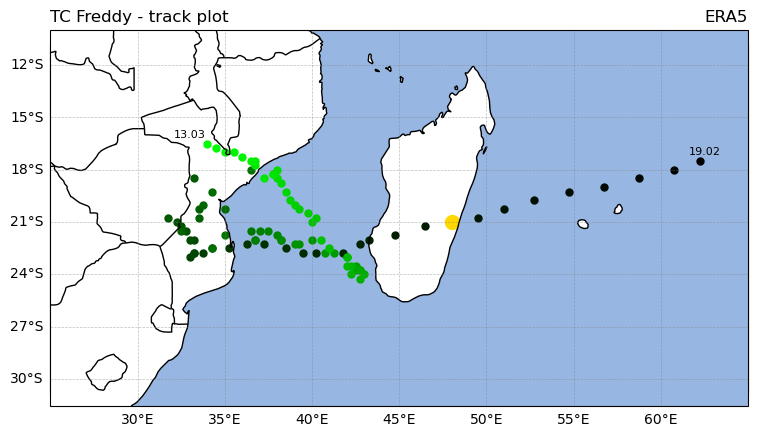

In [7]:
# Get the extent of your dataset
extent = [era.lon.min(), era.lon.max(), era.lat.min(), era.lat.max()]

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Define map projections
map_projection = ccrs.PlateCarree()
ax = plt.axes(projection=map_projection)


# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Specify the tick labels
gl.top_labels = False  # Disable labels on top
gl.right_labels = False  # Disable labels on right side
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Set the extent of the map
ax.set_extent(extent)

# Add coastlines and oceans
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)


# Define number of levels for the color gradient
num_levels = len(lats)

# Plot specific coordinates with a custom color gradient
for lon, lat, i in zip(lons, lats, range(num_levels)):
    # Create a custom colormap from black to red for each dot
    colors = [(0, 0, 0), (0, 1, 0)]  # Black to red
    custom_cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=num_levels)
    ax.scatter(lon, lat, marker='.', color=custom_cmap(i), s=100)

# Plot Points of future Analysis
ax.scatter(lons[8], lats[8], marker='.', color="gold", s=400)
#ax.scatter(lons[20], lats[20], marker='.', color="gold", s=400)

# add init times
ax.text(62.5,-17, "19.02", color='black', fontsize=8, ha='center', va='center',  transform=ccrs.PlateCarree())
ax.text(33,-16, "13.03", color='black', fontsize=8, ha='center', va='center',  transform=ccrs.PlateCarree())

# title variable description
ax.set_title("TC Freddy - track plot", loc ="left");
ax.set_title("ERA5", loc='right');
    
# save file in folder: plots    
plt.savefig("../plots/ERA_trackplot.png", dpi=300, bbox_inches='tight')
    
# Show the plot
plt.show()

**Extract all the lowest pressure (msl) coordinates from pangu from the appropriate init**

In [8]:
# from "2023-02-19T18:00:00.000000000" to "2023-03-13T12:00:00.000000000"

# pangu init 19.02 "2023-02-19T18:00:00.000000000" - "2023-02-23T12:00:00.000000000"
lats_1 = []
lons_1 = []

lats_2 = []
lons_2 = []


for i in list(range(16)):
    
    pangu_time = pangu.msl.sel( step = pangu.step[i], time = '2023-02-19T12:00:00.000000000',
                                      latitude = slice(-12,-27))
    
    min_value = pangu_time.min()
    
    # Find the positions where the array equals the desired value
    positions = (pangu_time == min_value).values.nonzero()
    
    # Extract the latitude and longitude coordinates corresponding to those positions
    lat = pangu_time.coords['latitude'].values[positions[0][0]]
    lon = pangu_time.coords['longitude'].values[positions[1][0]]
    
    lats_1.append(lat)
    lons_1.append(lon)
    
# pangu init 23.02 "2023-02-23T18:00:00.000000000" - "2023-03-13T12:00:00.000000000"
for i in list(range(13)):
    
    pangu_time = pangu.msl.sel( step = pangu.step[i], time = '2023-02-23T12:00:00.000000000')
    
    min_value = pangu_time.min()
    
    # Find the positions where the array equals the desired value
    positions = (pangu_time == min_value).values.nonzero()
    
    # Extract the latitude and longitude coordinates corresponding to those positions
    lat = pangu_time.coords['latitude'].values[positions[0][0]]
    lon = pangu_time.coords['longitude'].values[positions[1][0]]
    
    lats_2.append(lat)
    lons_2.append(lon)

**Pangu track plot**

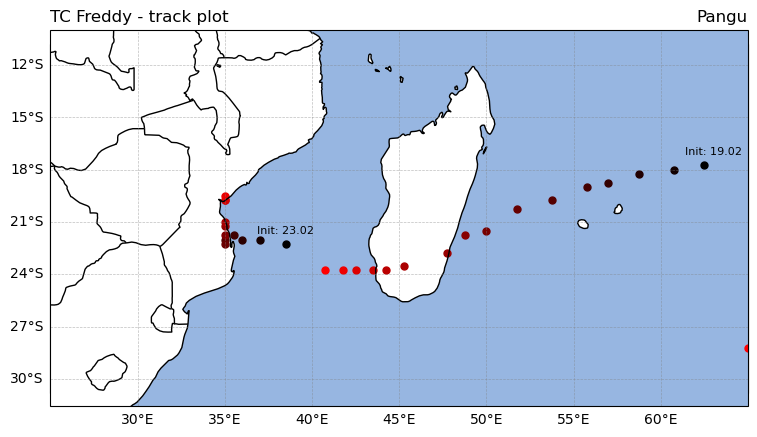

In [9]:
# Get the extent of your dataset
extent = [era.lon.min(), era.lon.max(), era.lat.min(), era.lat.max()]

# Create a new figure and axes
fig, ax = plt.subplots(figsize=(9, 5), subplot_kw=dict(projection=ccrs.PlateCarree()))

# Define map projections
map_projection = ccrs.PlateCarree()
ax = plt.axes(projection=map_projection)


# Gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')

# Specify the tick labels
gl.top_labels = False  # Disable labels on top
gl.right_labels = False  # Disable labels on right side
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Set the extent of the map
ax.set_extent(extent)

# Add coastlines and oceans
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.BORDERS)


# Define number of levels for the color gradient
num_levels = len(lats_1)

# Plot specific coordinates with a custom color gradient
for lon, lat, i in zip(lons_1, lats_1, range(num_levels)):
    # Create a custom colormap from black to red for each dot
    colors = [(0, 0, 0), (1, 0, 0)]  # Black to red
    custom_cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=num_levels)
    ax.scatter(lon, lat, marker='.', color=custom_cmap(i), s=100)

# Define number of levels for the color gradient
num_levels = len(lats_2)

# Plot specific coordinates with a custom color gradient
for lon, lat, i in zip(lons_2, lats_2, range(num_levels)):
    # Create a custom colormap from black to red for each dot
    colors = [(0, 0, 0), (1, 0, 0)]  # Black to red
    custom_cmap = LinearSegmentedColormap.from_list("custom_red", colors, N=num_levels)
    ax.scatter(lon, lat, marker='.', color=custom_cmap(i), s=100)
    
# title variable description
ax.set_title("TC Freddy - track plot", loc ="left");
ax.set_title("Pangu", loc='right');

# add init times
ax.text(63,-17, "Init: 19.02", color='black', fontsize=8, ha='center', va='center',  transform=ccrs.PlateCarree())
ax.text(38.5,-21.5, "Init: 23.02", color='black', fontsize=8, ha='center', va='center',  transform=ccrs.PlateCarree())
    
    
# save file in folder: plots    
plt.savefig("../plots/Pangu_trackplot.png", dpi=300, bbox_inches='tight')
    
# Show the plot
plt.show()

**Spatial distance of Pangu and ERA**

In [30]:
# Pangu only data for 29 6-hour intervals
# consequently, crop era to 0:28
lats_cropped = lats[0:28]
lons_cropped = lons[0:28]

# append pangu coordinates
lats_pangu = lats_1.copy()

for i in lats_2:
    lats_pangu.append(i)
    
for i in lons_2:
    lons_pangu.append(i)

# calculate distances
distances = []

for (lat_cropped, lon_cropped, lat_pangu, lon_pangu) in zip(lats_cropped, lons_cropped, lats_pangu, lons_pangu):
    result = haversine(lat_cropped, lon_cropped, lat_pangu, lon_pangu)
    distances.append(result)


# get x and y coordinates
x_1 = np.array(range(len(distances[:16]))).reshape((-1, 1))
y_1 = np.array(distances[:16])

x_2 = np.array(range(len(distances[16:]))).reshape((-1, 1))
y_2 = np.array(distances[16:])

model = LinearRegression()
m1 = model.fit(x_1,y_1)
m2 = model.fit(x_2, y_2)

In [24]:
print(f"coefficient of determination: "+ str(m2.score(x_2, y_2)))
print(f"slope: {m2.coef_}")


coefficient of determination: 0.9477761324781877
slope: [32.38012656]


**Plot the distances of the location of Freddy in Pangu and ERA**

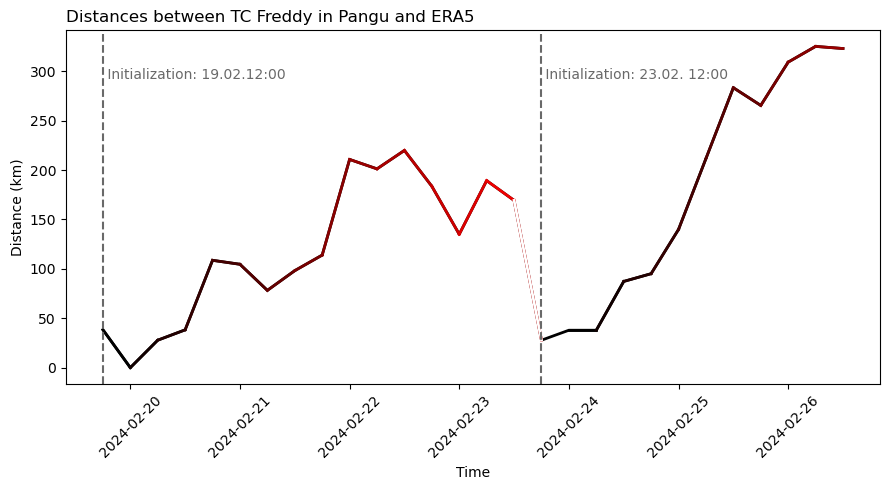

In [32]:
# Generate date sequence starting from "2024-02-19 18:00" and incrementing by 6 hours
start_date = dt.datetime(2024, 2, 19, 18, 0)
end_date = dt.datetime(2024, 2, 27, 0, 0)  # Set end date to "2024-02-27 00:00"
date_seq = [start_date + dt.timedelta(hours=6*i) for i in range(len(distances))]


# Set the size of the plot
plt.figure(figsize=(9, 5))

# Plot distances as a line plot
plt.plot(date_seq, distances, "-", color = "black", linewidth =2)

# custom colors for two gradients
color_scheme = ["#000000","#110000","#220000","#330000","#440000","#550000","#660000","#770000","#880000",
    "#990000","#AA0000","#BB0000","#CC0000","#DD0000","#EE0000","#FF0000","#FF0000"]

color_scheme_2 = ["#000000","#110000","#220000","#330000","#440000","#550000","#660000","#770000",
    "#880000","#990000","#AA0000","#BB0000","#CC0000","#FF0000"]
    
    
for i in range(len(date_seq[:16])):
    # Plot distances as a line plot
    plt.plot(date_seq[i:i+2], distances[i:i+2], "-", color = color_scheme[i], linewidth =2)
    
for i in range(len(date_seq[16:])):
    # Plot distances as a line plot
    plt.plot(date_seq[17+i:19+i], distances[17+i:19+i], "-", color = color_scheme_2[i], linewidth =2)

# Plot distances as a line plot
plt.plot(date_seq[15:17], distances[15:17], "-", color = "white", linewidth =2)

# Add a vertical line at index 15
plt.axvline(x=date_seq[16], color='dimgray', linestyle='--')
plt.axvline(x=date_seq[0], color='dimgray', linestyle='--')

# Add text inside the plot
plt.text(date_seq[0], distances[14]+100, ' Initialization: 19.02.12:00', color='dimgray', fontsize=10, va='bottom', ha='left')
plt.text(date_seq[16], distances[14]+100, ' Initialization: 23.02. 12:00', color='dimgray', fontsize=10, va='bottom', ha='left')
# Format x-axis ticks with date and time
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Set ticks on x-axis without labels
#plt.xticks(date_seq)
plt.xticks(rotation=45)

# Add labels and title
plt.xlabel('Time')
plt.ylabel('Distance (km)')
plt.title('Distances between TC Freddy in Pangu and ERA5', loc = "left")

# save file in folder: plots    
plt.savefig("../plots/Distances_trackplot.png", dpi=300, bbox_inches='tight')


# Show plot
plt.tight_layout()
plt.show()
